## 用卷积神经网络训练Cifar10
For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

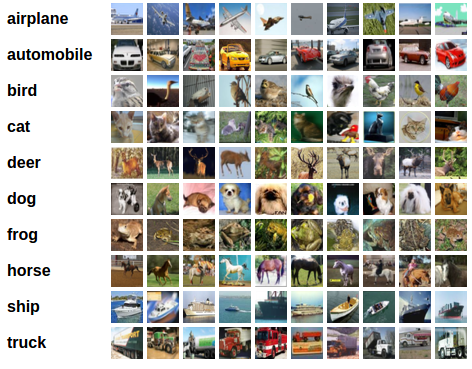

## Training an image classifier
We will do the following steps in order:
- Load and normalize the CIFAR10 training and test datasets using torchvision
- Define a Convolutional Neural Network
- Define a loss function
- Train the network on the training data
- Test the network on the test data

## 1. Load and normalize CIFAR10
Using torchvision, it's extremely easy to load CIFAR10.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

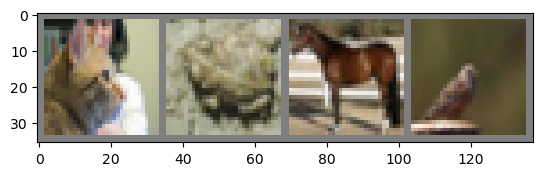

cat   frog  horse bird 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 2. Define a Convolutional Neural Network


In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 4, 6, 28, 28
        self.pool = nn.MaxPool2d(2, 2) # 4, 6, 14，14
        self.conv2 = nn.Conv2d(6, 16, 5) # 4, 16, 10，10
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
#         x = self.conv1(x)
#         print("output shape of conv1:", x.size())
#         x = F.relu(x)
        
#         x = self.pool(x)
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,3,1,1,bias=False)


        self.short_cut = nn.Sequential()
        if stride != 1:
            self.short_cut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out=self.bn1(out)
        out = out + self.short_cut(x)
        return F.relu(out)



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        # self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 自适应池化到1x1大小
        self.linear = nn.Linear(128, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        strides = [stride] + [1]*(num_blocks-1)  # 第一个block的stride可能不为1，其余为1
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        # out = self.layer3(out)
        # out = self.layer4(out)
        out = self.avgpool(out)  # 使用自适应平均池化
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

resnet = ResNet(BasicBlock, [2, 2], num_classes=10)
print(resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (short_cut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (short_cut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), 

In [33]:
class BN_Conv2d(nn.Module):

    def __init__(self, in_channels: object, out_channels: object, kernel_size: object, stride: object, padding: object,
                 dilation=1, groups=1, bias=False) -> object:
        super(BN_Conv2d, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,
                      padding=padding, dilation=dilation, groups=groups, bias=bias),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return F.relu(self.seq(x))

class DenseBlock(nn.Module):
    def __init__(self, input_channels, num_layers, growth_rate):
        super(DenseBlock, self).__init__()
        self.num_layers = num_layers
        self.k0 = input_channels
        self.k = growth_rate
        self.layers = self.__make_layers()

    def __make_layers(self):
        layer_list = []
        for i in range(self.num_layers):
            layer_list.append(nn.Sequential(
                BN_Conv2d(self.k0+i*self.k, 4*self.k, 1, 1, 0),
                BN_Conv2d(4 * self.k, self.k, 3, 1, 1)
            ))
        return layer_list

    def forward(self, x):
        feature = self.layers[0](x)
        out = torch.cat((x, feature), 1)
        for i in range(1, len(self.layers)):
            feature = self.layers[i](out)
            out = torch.cat((feature, out), 1)
        return out

class DenseNet(nn.Module):
    def __init__(self, layers: object, k, theta, num_classes) -> object:
        super(DenseNet, self).__init__()
        # params
        self.layers = layers
        self.k = k
        self.theta = theta
        # layers
        self.conv = BN_Conv2d(3, 2*k, 7, 2, 3)
        self.blocks, patches = self.__make_blocks(2*k)
        self.fc = nn.Linear(patches, num_classes)

    def __make_transition(self, in_chls):
        out_chls = int(self.theta*in_chls)
        return nn.Sequential(
            BN_Conv2d(in_chls, out_chls, 1, 1, 0),
            nn.AvgPool2d(2)
        ), out_chls

    def __make_blocks(self, k0):
        """
        make block-transition structures
        :param k0:
        :return:
        """
        layers_list = []
        patches = 0
        for i in range(len(self.layers)):
            layers_list.append(DenseBlock(k0, self.layers[i], self.k))
            patches = k0+self.layers[i]*self.k      # output feature patches from Dense Block
            if i != len(self.layers)-1:
                transition, k0 = self.__make_transition(patches)
                layers_list.append(transition)
        return nn.Sequential(*layers_list), patches

    def forward(self, x):
        out = self.conv(x)
        out = F.max_pool2d(out, 3, 2, 1)
        # print(out.shape)
        out = self.blocks(out)
        # print(out.shape)
        # out = F.avg_pool2d(out, 7)
        # 使用全局平均池化来处理任意尺寸的特征图
        out = F.adaptive_avg_pool2d(out, (1, 1))
        # print(out.shape)
        out = out.view(out.size(0), -1)
        out = F.softmax(self.fc(out))
        return out
    
densenet=DenseNet([2, 2, 2, 2], k=16, theta=0.5, num_classes=10)
print(densenet)

DenseNet(
  (conv): BN_Conv2d(
    (seq): Sequential(
      (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (blocks): Sequential(
    (0): DenseBlock()
    (1): Sequential(
      (0): BN_Conv2d(
        (seq): Sequential(
          (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (2): DenseBlock()
    (3): Sequential(
      (0): BN_Conv2d(
        (seq): Sequential(
          (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (4): DenseBlock()
    (5): Sequential(


In [30]:
import torch.nn as nn
import torch.nn.functional as F

class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        inner_channel = 4 * growth_rate

        self.bottle_neck = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, inner_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(inner_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(inner_channel, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1)

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=100):
        super().__init__()
        self.growth_rate = growth_rate

        inner_channels = 2 * growth_rate

        self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False)

        self.features = nn.Sequential()

        for index in range(len(nblocks) - 1):
            self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, inner_channels, nblocks[index]))
            inner_channels += growth_rate * nblocks[index]

            out_channels = int(reduction * inner_channels) # int() will automatic floor the value
            self.features.add_module("transition_layer_{}".format(index), Transition(inner_channels, out_channels))
            inner_channels = out_channels

        self.features.add_module("dense_block{}".format(len(nblocks) - 1), self._make_dense_layers(block, inner_channels, nblocks[len(nblocks)-1]))
        inner_channels += growth_rate * nblocks[len(nblocks) - 1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU(inplace=True))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear = nn.Linear(inner_channels, num_class)

    def forward(self, x):
        output = self.conv1(x)
        output = self.features(output)
        output = self.avgpool(output)
        output = output.view(output.size()[0], -1)
        output = self.linear(output)
        return output

    def _make_dense_layers(self, block, in_channels, nblocks):
        dense_block = nn.Sequential()
        for index in range(nblocks):
            dense_block.add_module('bottle_neck_layer_{}'.format(index), block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return dense_block


densenet=DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)
print(densenet)



DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (features): Sequential(
    (dense_block_layer_0): Sequential(
      (bottle_neck_layer_0): Bottleneck(
        (bottle_neck): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
          (5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (bottle_neck_layer_1): Bottleneck(
        (bottle_neck): Sequential(
          (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(12

In [18]:
import torch
import torch.nn as nn
 
 
def standard_conv_block(in_channel, out_channel, strid=1):  # 定义Strandard convolutional layer with batchnorm and ReLU
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, 3, strid, 1, bias=False),  # conv
        nn.BatchNorm2d(out_channel),  # bn
        nn.ReLU()  # relu
    )
 
 
def depthwise_separable_conv_block(in_channel, out_channel,
                                   strid=1):  # 定义Depthwise Separable convolutions with Depthwise and Pointwise layers followed by batchnorm and ReLU
    return nn.Sequential(
        nn.Conv2d(in_channel, in_channel, 3, strid, 1, groups=in_channel, bias=False),  # conv,使用与输入通道数相同组数的分组卷积实现Depthwise Convolution
        nn.BatchNorm2d(in_channel),  # bn
        nn.ReLU(),  # relu
        nn.Conv2d(in_channel, out_channel, 1, 1, 0, bias=False),  # 1x1conv,Pointwise Convolution
        nn.BatchNorm2d(out_channel),  # bn
        nn.ReLU()  # relu
    )
 
 
class MobileNetV1(nn.Module):  # 定义MobileNet结构
    def __init__(self, num_classes=10):  # 初始化方法
        super(MobileNetV1, self).__init__()  # 继承初始化方法
 
        self.num_classes = num_classes  # 类别数量
        self.feature = nn.Sequential(  # 特征提取部分
            standard_conv_block(3, 4, strid=2),  # standard conv block,(n,3,32,32)-->(n,4,32,32)
            depthwise_separable_conv_block(4, 8,strid=2),  # depthwise separable conv block,(n,4,32,32)-->(n,8,16,16)
            depthwise_separable_conv_block(8, 8),  # depthwise separable conv block,(n,8,16,16)-->(n,8,16,16)
            depthwise_separable_conv_block(8, 16, strid=2),  # depthwise separable conv block,(n,8,16,16)-->(n,16,8,8)
            depthwise_separable_conv_block(16, 16),  # depthwise separable conv block,(n,16,8,8)-->(n,16,8,8)
            depthwise_separable_conv_block(16, 32, strid=2),  # depthwise separable conv block,(n,16,8,8)-->(n,16,4,4)
            depthwise_separable_conv_block(32, 64),  # depthwise separable conv block,(n,16,4,4)-->(n,16,2,2)
            depthwise_separable_conv_block(64, 128, strid=2),  # depthwise separable conv block,(n,16,2,2)-->(n,16,1,1)
            nn.AdaptiveAvgPool2d(1)  # avgpool,为方便后续转为特征向量,这里将avgpool放入特征提取部分,(n,1024,7,7)-->(n,1024,1,1)
        )
        self.classifier = nn.Sequential(  # 分类部分
            nn.Linear(128, self.num_classes),  # linear,(n,16)-->(n,num_classes)
            # nn.Softmax(dim=1)  # softmax
        )
 
    def forward(self, x):  # 前传函数
        x = self.feature(x)  # 特征提取，获得特征层,(n,16,1,1)
        x = torch.flatten(x, 1)  # 将三维特征层压缩至一维特征向量,(n,16,1,1)-->(n,16)
        return self.classifier(x)  # 分类，输出类别概率,(n,num_classes)
    
mobilenet=MobileNetV1()
print(mobilenet)

MobileNetV1(
  (feature): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4, bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(4, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(8, eps=1e

## 3. Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [34]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(resnet.parameters(), lr=0.1, momentum=0.9)
# optimizer = optim.SGD(mobilenet.parameters(), lr=0.1, momentum=0.9)
optimizer = optim.SGD(densenet.parameters(), lr=0.01, momentum=0.9)  # learning rate 可以根据实际情况调整
# optimizer = optim.Adam(densenet.parameters(), lr=0.005)

# mobile net
# 损失函数
# criterion = nn.SmoothL1Loss()

# 优化器
# optimizer = optim.Adam(mobilenet.parameters(), lr=0.01)




## 4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

C:\Users\29467\AppData\Local\Temp\ipykernel_18456\2461552208.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.fc(out))


[1,   100] loss: 2.299, accuracy: 13.500%
[1,   200] loss: 2.296, accuracy: 13.000%
[1,   300] loss: 2.293, accuracy: 12.000%
[1,   400] loss: 2.279, accuracy: 15.500%
[1,   500] loss: 2.265, accuracy: 16.750%
[1,   600] loss: 2.279, accuracy: 15.750%
[1,   700] loss: 2.272, accuracy: 17.000%
[1,   800] loss: 2.256, accuracy: 19.500%
[1,   900] loss: 2.268, accuracy: 18.000%
[1,  1000] loss: 2.251, accuracy: 19.500%
[1,  1100] loss: 2.250, accuracy: 18.500%
[1,  1200] loss: 2.264, accuracy: 17.000%
[1,  1300] loss: 2.240, accuracy: 19.250%
[1,  1400] loss: 2.250, accuracy: 17.750%
[1,  1500] loss: 2.217, accuracy: 23.750%
[1,  1600] loss: 2.226, accuracy: 23.000%
[1,  1700] loss: 2.259, accuracy: 15.500%
[1,  1800] loss: 2.236, accuracy: 21.500%
[1,  1900] loss: 2.245, accuracy: 19.750%
[1,  2000] loss: 2.227, accuracy: 23.000%
[1,  2100] loss: 2.244, accuracy: 18.750%
[1,  2200] loss: 2.247, accuracy: 18.500%
[1,  2300] loss: 2.233, accuracy: 20.750%
[1,  2400] loss: 2.228, accuracy: 

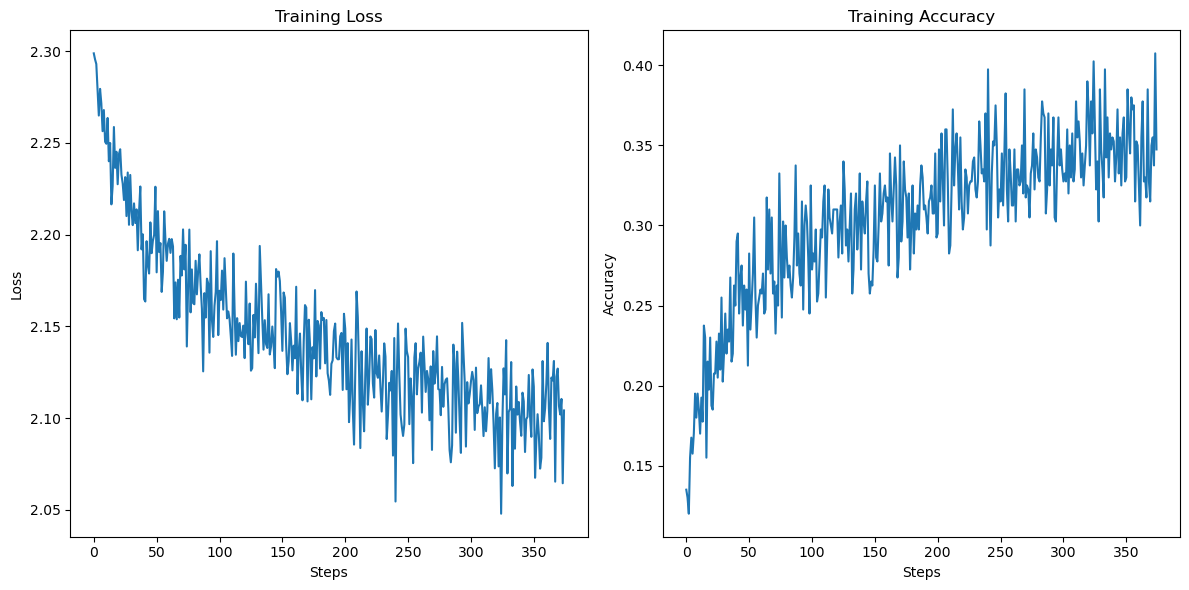

In [35]:
import matplotlib.pyplot as plt

# 初始化列表来收集损失值和准确率
losses = []
accuracies = []
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # outputs = resnet(inputs)
        outputs = densenet(inputs)
        # outputs=mobilenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:    # print every 2000 mini-batches
            average_loss = running_loss / 100
            accuracy = correct / total
            acc=accuracy*100
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {average_loss:.3f}, accuracy: {acc:.3f}%')
            losses.append(average_loss)
            accuracies.append(accuracy)
            running_loss = 0.0
            correct = 0
            total = 0

print('Finished Training')
# 绘制损失和准确率图
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Training Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

Let’s quickly save our trained model:

In [23]:
# PATH = './cifar_resnet.pth'
# torch.save(resnet.state_dict(), PATH)
PATH = './cifar_densenet.pth'
torch.save(densenet.state_dict(), PATH)
# PATH = './cifar_mobilenet.pth'
# torch.save(mobilenet.state_dict(), PATH)

## 5. Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

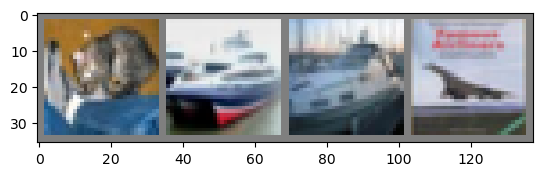

GroundTruth:  cat   ship  ship  plane


In [24]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [26]:
#net = Net()
# net=ResNet(BasicBlock,[2,2])
# net=MobileNetV1()

net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:

In [27]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [28]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  frog  plane horse cat  


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

In [29]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 29 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [13]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 73.4 %
Accuracy for class: car   is 87.7 %
Accuracy for class: bird  is 47.9 %
Accuracy for class: cat   is 63.7 %
Accuracy for class: deer  is 79.1 %
Accuracy for class: dog   is 49.5 %
Accuracy for class: frog  is 83.4 %
Accuracy for class: horse is 66.4 %
Accuracy for class: ship  is 94.5 %
Accuracy for class: truck is 74.1 %


Net第一次实验结果：54%
Accuracy for class: plane is 47.0 %
Accuracy for class: car   is 57.9 %
Accuracy for class: bird  is 52.9 %
Accuracy for class: cat   is 21.0 %
Accuracy for class: deer  is 48.4 %
Accuracy for class: dog   is 45.9 %
Accuracy for class: frog  is 53.7 %
Accuracy for class: horse is 63.6 %
Accuracy for class: ship  is 82.2 %
Accuracy for class: truck is 68.6 %


ResNet第一次实验结果：53%(此时只训练了一个epoch)
Accuracy for class: plane is 50.2 %
Accuracy for class: car   is 47.2 %
Accuracy for class: bird  is 42.6 %
Accuracy for class: cat   is 32.5 %
Accuracy for class: deer  is 56.8 %
Accuracy for class: dog   is 20.0 %
Accuracy for class: frog  is 65.3 %
Accuracy for class: horse is 65.9 %
Accuracy for class: ship  is 79.8 %
Accuracy for class: truck is 79.4 %

ResNet第二次实验结果：71%(此时是训练了三个epoch)
Accuracy for class: plane is 73.4 %
Accuracy for class: car   is 87.7 %
Accuracy for class: bird  is 47.9 %
Accuracy for class: cat   is 63.7 %
Accuracy for class: deer  is 79.1 %
Accuracy for class: dog   is 49.5 %
Accuracy for class: frog  is 83.4 %
Accuracy for class: horse is 66.4 %
Accuracy for class: ship  is 94.5 %
Accuracy for class: truck is 74.1 %
